## Introduction to Linear Regression

In [193]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split, KFold
import math


# this allows plots to appear directly in the notebook
%matplotlib inline
sn.set()

In [194]:
# read data into a DataFrame
data = pd.read_csv('http://www-bcf.usc.edu/~gareth/ISL/Advertising.csv', index_col=0)
data.columns = ['TV', 'Radio', 'Newspaper', 'Sales']
data.head()

,TV,Radio,Newspaper,Sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


What are the features?

- TV: advertising dollars spent on TV for a single product in a given market (in thousands of dollars)
- Radio: advertising dollars spent on Radio
- Newspaper: advertising dollars spent on Newspaper

What is the label?

- Sales: sales of a single product in a given market (in thousands of widgets)


In [195]:
print(data.shape)

(200, 4)


There are 200 observations, and thus 200 markets in the dataset.

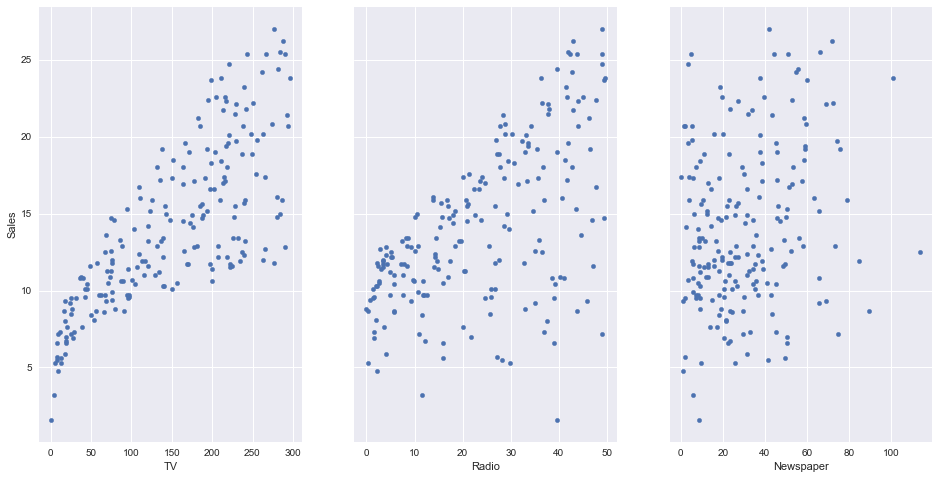

In [196]:
# visualize the relationship between the features and the response using scatterplots
fig, axs = plt.subplots(1, 3, sharey=True)
data.plot(kind='scatter', x='TV', y='Sales', ax=axs[0], figsize=(16, 8))
data.plot(kind='scatter', x='Radio', y='Sales', ax=axs[1])
data.plot(kind='scatter', x='Newspaper', y='Sales', ax=axs[2])
plt.show()

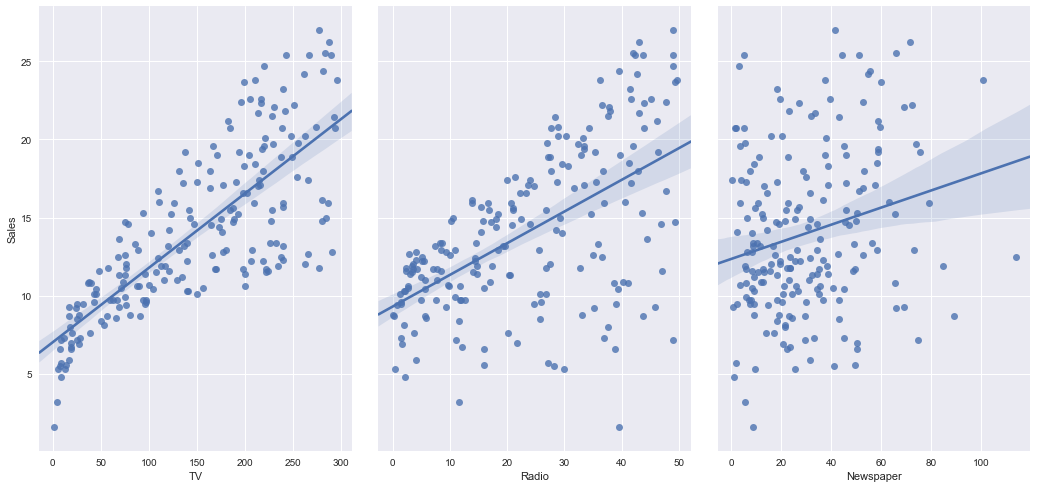

In [197]:
# visualize the relationship between the features and the response using scatterplots
sn.pairplot(data, x_vars=['TV','Radio','Newspaper'], y_vars='Sales', size=7, aspect=0.7, kind='reg')
plt.show()

### Evaluate Linear Regression model

In [198]:
# create X and y
feature_cols = ['TV', 'Radio', 'Newspaper']
X = data[feature_cols]
y = data.Sales

### Using train/test split

In [199]:
def predict_and_evaluate_regression(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print ("R2 score: %.5f" % r2_score(y_test, y_pred))
    print ("RMSE: %.5f" % math.sqrt(mean_squared_error(y_test, y_pred)))
    return y_pred

# use train/test split with different random_state values
X_train, X_test, y_train, y_test = train_test_split(X, y)
    
model = LinearRegression()
model.fit(X_train, y_train)

pred = predict_and_evaluate_regression(model, X_test, y_test)

R2 score: 0.92237
RMSE: 1.57733


In [200]:
def train_and_evaluate_regression(model, X_train, y_train, k_folds=10):
    model.fit(X_train, y_train)
    print ("R2 Score on training set: ", model.score(X_train, y_train))   
    scores = cross_val_score(model, X_train, y_train, cv=k_folds, scoring='neg_mean_squared_error')
    scores = np.sqrt(-scores)
    print ("Average RMSE score using %i-fold crossvalidation: " %k_folds, np.mean(scores))
    return scores
    
model = LinearRegression()
scores = train_and_evaluate_regression(model, X, y)

R2 Score on training set:  0.897210638179
Average RMSE score using 10-fold crossvalidation:  1.69135317081


In [201]:
# pair the feature names with the coefficients, order them and show absolute values
def getCoefficientsDataFrame(feature_names, coefs):
    T = pd.DataFrame()
    T['feature'] = feature_names
    T['coefs'] = coefs
    T['weight'] = T['coefs'].apply(lambda x: math.fabs(x))
    return T.sort_values(by='weight', ascending=False)

getCoefficientsDataFrame(feature_cols,model.coef_)

,feature,coefs,weight
1,Radio,0.188530,0.188530
0,TV,0.045765,0.045765
2,Newspaper,-0.001037,0.001037


In [202]:
# without using pandas
def getKey(item):
     return item[2]
    
coeffs = list(zip(feature_cols, model.coef_, np.abs(model.coef_)))
sorted(coeffs,key=getKey,reverse=True)

[('Radio', 0.18853001691820456, 0.18853001691820456),
 ('TV', 0.045764645455397615, 0.045764645455397615),
 ('Newspaper', -0.0010374930424763272, 0.0010374930424763272)]

In [203]:
# predict for a new observation
model.predict([[100, 25, 25]])

array([ 12.20266701])

### Handling Categorical Predictors with Two Categories

Up to now, all of our predictors have been numeric. What if one of our predictors was categorical?

Let's create a new feature called Size, and randomly assign observations to be small or large:


In [204]:
import numpy as np

# set a seed for reproducibility
np.random.seed(12345)

# create a Series of booleans in which roughly half are True
nums = np.random.rand(len(data))
mask_large = nums > 0.5

# initially set Size to small, then change roughly half to be large
data['Size'] = 'small'
data.loc[mask_large, 'Size'] = 'large'
data.head()

,TV,Radio,Newspaper,Sales,Size
1,230.1,37.8,69.2,22.1,large
2,44.5,39.3,45.1,10.4,small
3,17.2,45.9,69.3,9.3,small
4,151.5,41.3,58.5,18.5,small
5,180.8,10.8,58.4,12.9,large


In [205]:
# create a new Series called IsLarge
data['IsLarge'] = data.Size.map({'small':0, 'large':1})
data.head()

,TV,Radio,Newspaper,Sales,Size,IsLarge
1,230.1,37.8,69.2,22.1,large,1
2,44.5,39.3,45.1,10.4,small,0
3,17.2,45.9,69.3,9.3,small,0
4,151.5,41.3,58.5,18.5,small,0
5,180.8,10.8,58.4,12.9,large,1


In [206]:
# create X and y
feature_cols = ['TV', 'Radio', 'Newspaper', 'IsLarge']
X = data[feature_cols]
y = data.Sales

# instantiate, fit
model = LinearRegression()
model.fit(X, y)

# print coefficients
getCoefficientsDataFrame(feature_cols,model.coef_)

,feature,coefs,weight
1,Radio,0.188728,0.188728
3,IsLarge,0.057424,0.057424
0,TV,0.045720,0.045720
2,Newspaper,-0.001098,0.001098


### Handling Categorical Predictors with More than Two Categories

Let's create a new feature called Area, and randomly assign observations to be rural, suburban, or urban:


In [207]:
# set a seed for reproducibility
np.random.seed(123456)

# assign roughly one third of observations to each group
nums = np.random.rand(len(data))
mask_suburban = (nums > 0.33) & (nums < 0.66)
mask_urban = nums > 0.66
data['Area'] = 'rural'
data.loc[mask_suburban, 'Area'] = 'suburban'
data.loc[mask_urban, 'Area'] = 'urban'
data.head()

,TV,Radio,Newspaper,Sales,Size,IsLarge,Area
1,230.1,37.8,69.2,22.1,large,1,rural
2,44.5,39.3,45.1,10.4,small,0,urban
3,17.2,45.9,69.3,9.3,small,0,rural
4,151.5,41.3,58.5,18.5,small,0,urban
5,180.8,10.8,58.4,12.9,large,1,suburban


In [209]:
def OneHotEncode(x):
    categorical = x.select_dtypes(exclude=[np.number])
    return pd.get_dummies(x, columns=categorical.columns)

def makeCategorical(x, feature, value_list):
    return x[feature].astype(pd.api.types.CategoricalDtype(categories = value_list))

new_data = data

print ("Area appears as an 'object' column\n")
print (new_data.dtypes)

#this step is not really required but it helps in case the training data and test data display different values
new_data.Area = makeCategorical(new_data, 'Area', ['rural', 'suburban', 'urban'])

print("\n")
print ("Area appears as an category column\n")
print (new_data.dtypes)

new_data = OneHotEncode(new_data)
print("\n")
print ("Three new dummie variables appear\n")
print (new_data.dtypes)

Area appears as an 'object' column

TV            float64
Radio         float64
Newspaper     float64
Sales         float64
Size           object
IsLarge         int64
Area         category
dtype: object


Area appears as an category column

TV            float64
Radio         float64
Newspaper     float64
Sales         float64
Size           object
IsLarge         int64
Area         category
dtype: object


Three new dummie variables appear

TV               float64
Radio            float64
Newspaper        float64
Sales            float64
IsLarge            int64
Size_large         uint8
Size_small         uint8
Area_rural         uint8
Area_suburban      uint8
Area_urban         uint8
dtype: object


In [220]:
#checking the encoding is correctly done
original = data.loc[:,'Area'].head(5)
new = new_data.iloc[:,-3:].head(5)
pd.concat([original, new], axis=1)

,Area,Area_rural,Area_suburban,Area_urban
1,rural,1,0,0
2,urban,0,0,1
3,rural,1,0,0
4,urban,0,0,1
5,suburban,0,1,0


In [224]:
# create X and y
feature_cols = ['TV', 'Radio', 'Newspaper', 'IsLarge', 'Area_rural', 'Area_suburban', 'Area_urban']
X = new_data[feature_cols]
y = new_data.Sales

# instantiate, fit
model = LinearRegression()
model.fit(X, y)

# print coefficients
getCoefficientsDataFrame(feature_cols,model.coef_)

,feature,coefs,weight
6,Area_urban,0.214280,0.214280
1,Radio,0.187867,0.187867
5,Area_suburban,-0.160421,0.160421
3,IsLarge,0.077397,0.077397
4,Area_rural,-0.053858,0.053858
0,TV,0.045744,0.045744
2,Newspaper,-0.001088,0.001088


A final note about **dummy encoding**: If you have categories that can be ranked (i.e., strongly disagree, disagree, neutral, agree, strongly agree), you can potentially use a single dummy variable and represent the categories numerically (such as 1, 2, 3, 4, 5).